# affine-invariant MCMC package testing (Julia)

In [1]:
using Plots
using BenchmarkTools
using LaTeXStrings
using Distributions
using Statistics
using Printf

### Create mock data

The mock data we will create is drawn from the distribution $f$ which has PDF 
$$f(v| v_{esc},k) = \frac{k+1}{v_{esc}{}^{k+1}} (v_{esc} - v)^k \quad,\quad v\in[0,v_{esc}]$$

and CDF
$$ \text{CDF}_f(v) =  \left( 1 - \frac{v}{v_{esc}} \right)^{k+1} -1 \quad,\quad v\in[0,v_{esc}]$$

which has inverse 
$$  \text{CDF}_f{}^{-1}(y) = v_{esc}\left[ 1 - (1-y)^{\frac{1}{k+1}}  \right] \quad,\quad y\in[0,1] $$

We need the inverse CDF to generate samples from this distribution. Note also that the log likelihood is given by
$$ Log\left(\text{Likelihood} (D|v_{esc},k)  \right) = \sum_d Log(f(d|vesc,k)  ) $$

for a dataset D consisting of datapoints $d$, where each term is of the form
$$  Log(f(d|vesc,k)  ) =  Log(k+1) - (k+1)Log(v_{esc}) + k~Log(v_{esc} - v) $$

In [2]:
function powerlaw_PDF(v,x)
    vesc,k = x
    return ( (k+1)*(vesc)^(-k-1) ) * (vesc - v)^k
end

function powerlaw_inverse_CDF(y,x)
    vesc,k = x
    return vesc*( 1.0 - (1.0-y)^( 1.0/(k+1.0) ) )
end

powerlaw_inverse_CDF (generic function with 1 method)

### Define helper functions

In [3]:
function generate_samples(N,inverse_CDF::Function,x)
    # To sample from a distribution we perform inverse transform sampling, for which the inverse CDF is required
    uniform_random_numbers = rand(Float64,N)
    
    return map( num -> inverse_CDF(num,x) , uniform_random_numbers )
end

generate_samples (generic function with 1 method)

### Sample from distribution to obtain data which we will fit via MCMC

We generate data with a specific escape velocity and $k$ to use in our parameter fit later

In [4]:
target_vesc = 550.0
target_k = 3.0
target_x = [target_vesc,target_k]
num_samples = 1000

target_data = generate_samples(num_samples,powerlaw_inverse_CDF,target_x);

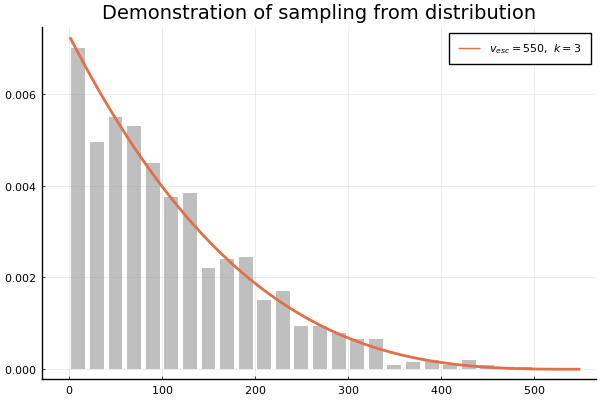

In [5]:
pyplot()

histogram(target_data, normed = true,
                    bins = 25,
                    title = "Demonstration of sampling from distribution",
                    alpha = 0.5,
                    bar_width = 15,
                    linewidth = 0,
                    color = "gray" ,
                    label = ""
                    )

v_test = collect(1:1:550)
plot!(v_test, map(v -> powerlaw_PDF(v,[550.0,3.0]) , v_test) ,
                    linewidth = 2,
                    #color = "red",
                    label = L"v_{esc}=550,~k=3"
                    )

# Define MCMC functions and parameters

In [6]:
function log_prior(x)
    vesc,k = x
    if 100.0 < vesc < 800.0 && 0.2 < k < 10.0 
        return 0.0
    end

    return -Inf
end

function log_likelihood(x,data)
    vesc,k = x
    sum = 0.0
    for v in data
        #println("v = ",v,", vesc = ",vesc)
        if v < vesc
            sum += log(k+1.0) - (k+1.0)*log(vesc) + k*log(vesc - v)
        else
            return -Inf 
        end
    end
    return sum
end

function log_probability(x,data)
    return log_likelihood(x,data) + log_prior(x)
end

log_probability (generic function with 1 method)

# Use AffineInvariantMCMC to perform sampling

In [7]:
import AffineInvariantMCMC

### Parameters and initial conditions for walkers

In [25]:
# Parameters
ndims = 2
nwalkers = 10
thinning = 10
nsamples_perwalker = 1000
burnin = 100

# ICs
guess_vesc = 600
guess_k = 4

initial_guess_dist = 

initial_guess_onewalker = [guess_vesc,guess_k]
initial_guess = reduce(hcat, [initial_guess_onewalker + vec(rand(MvNormal([0.0,0.0],[90 0.0 ; 0.0 0.9]) , 1))  for _ in 1:nwalkers])

quantile_list = [0.16, 0.5, 0.84];


In [26]:
rand(MvNormal([guess_vesc,guess_k],[90 0.0 ; 0.0 0.9]) , 1)

2×1 Matrix{Float64}:
 576.9717611845572
   4.007093888773608

In [27]:
initial_guess

2×10 Matrix{Float64}:
 603.297    584.489    604.618    …  612.354    591.99     603.498
   5.16771    3.12128    4.03243       3.10423    3.22632    4.25786

In [20]:
chain, log_likelihood_vals = AffineInvariantMCMC.sample(log_probability, nwalkers, initial_guess, burnin, 1)
#chain, log_likelihood_vals = AffineInvariantMCMC.sample(llhood, numwalkers, chain[:, :, end], numsamples_perwalker, thinning)
#flatchain, flatllhoodvals = AffineInvariantMCMC.flattenmcmcarray(chain, llhoodvals)

MethodError: MethodError: no method matching log_probability(::Vector{Float64})
Closest candidates are:
  log_probability(::Any, !Matched::Any) at c:\Users\CianM\OneDrive - Massachusetts Institute of Technology\Documents\MIT\6338\final_project\AIMCMC.ipynb:24

# Run MH algorithm

In [46]:
num_steps = 40000
burnin = 200
initial_guess = [600.0,4.0]

quantile_list = [0.16, 0.5, 0.84]

accepted, rejected = metropolis_hastings(target_data, 
                                        num_steps,
                                        initial_guess,
                                        log_likelihood, 
                                        log_prior, 
                                        step_model, 
                                        step_decision
                                        )

([0.0 582.792783664639 … 0.0 0.0; 0.0 3.2850577795645868 … 0.0 0.0], [600.014602356757 0.0 … 552.2736547370711 566.9570035181895; 2.881099665986132 0.0 … 1.677559345788331 1.5424387372482846])

### Strip the zeros

In [118]:
accepted_col_indices = zeros(Int64,0)
rejected_col_indices = zeros(Int64,0)

for (i,col) in enumerate(eachcol(accepted))
    if col != [0,0]
        append!(accepted_col_indices,i)
    end
end

for (i,col) in enumerate(eachcol(rejected))
    if col != [0,0]
        append!(rejected_col_indices,i)
    end
end

accepted_stripped = accepted[:,accepted_col_indices]
rejected_stripped = rejected[:,rejected_col_indices];

0.048850197970474865


### Process the data

In [ ]:
# final data to be used
vesc_posterior = accepted_stripped[1,burnin:end]
k_posterior = accepted_stripped[2,burnin:end]

# Examine acceptance fraction
println(length(accepted_stripped) / length(rejected_stripped)) # a decent proxy for real value

# Establish estimates of parameters via median and expected error on these estimates
vesc_quantiles = quantile(vesc_posterior, quantile_list)
k_quantiles = quantile(k_posterior, quantile_list)


vesc_median = vesc_quantiles[2]
vesc_lower_1sigma = vesc_median - vesc_quantiles[1]
vesc_upper_1sigma = vesc_quantiles[3] - vesc_median

k_median = k_quantiles[2]
k_lower_1sigma = k_median - k_quantiles[1]
k_upper_1sigma = k_quantiles[3] - k_median;

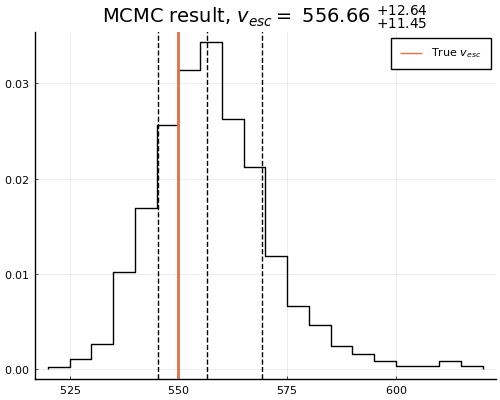

In [128]:
plot(vesc_posterior, normed = true,
                    bins = 25,
                    title = "MCMC result, \$v_{esc} =\$ $(@sprintf("%.2f", vesc_median)) \$ ^{+$(@sprintf("%.2f", vesc_upper_1sigma))}_{+$(@sprintf("%.2f", vesc_lower_1sigma))}\$ ",
                    #alpha = 0.5,
                    #bar_width = 15,
                    #linewidth = 0,
                    #color = "gray" ,
                    lc="black",
                    label = "",
                    seriestype=:stephist,
                    size=(500,400),
                    )
vline!([target_vesc], lw = 2, label = L"True $v_{esc}$")

vline!(vesc_quantiles , ls=:dash, color="black",lw=1,label="" )

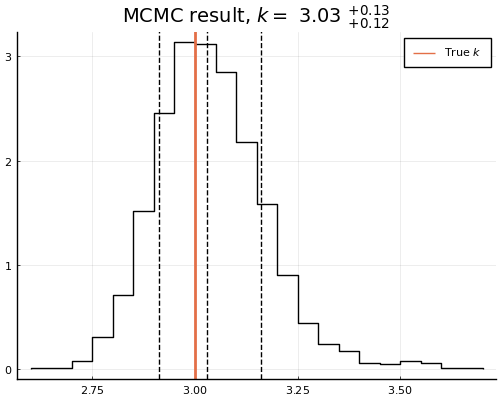

In [129]:
plot(k_posterior, normed = true,
                    bins = 25,
                    title = "MCMC result, \$k =\$ $(@sprintf("%.2f", k_median)) \$ ^{+$(@sprintf("%.2f", k_upper_1sigma))}_{+$(@sprintf("%.2f", k_lower_1sigma))}\$ ",
                    #alpha = 0.5,
                    #bar_width = 15,
                    #linewidth = 0,
                    #color = "gray" ,
                    lc="black",
                    label = "",
                    seriestype=:stephist,
                    size=(500,400),
                    )
vline!([target_k], lw = 2, label = L"True $k$")

vline!( k_quantiles, ls=:dash, color="black",lw=1, label="")